In [996]:
import tensorflow as tf
from datetime import datetime   # As the code can be run many time, each time 
                                # a new log file for TensorBoard is created in a separate
                                # directory named with current date and time
from os.path import join        # use join function when creating paths
import numpy as np
import matplotlib.pyplot as plt

In [997]:
tf.__version__

'1.4.0'

In [998]:
LOGDIR_ROOT = '/home/damian/GitRepositories/TensorFlow_wormUp_gym/SimpleNN_and_tensorboard/log_01'

In [999]:
N = 100 # Number of data points per single class
D = 2   # Dimensionality of the data
K = 3   # Number of classes

In [1000]:
seed_val = 121
np.random.seed(seed_val)
X = np.zeros( (N * K, D), dtype='float32' )          # shape (300, 2)
print(X.dtype)
y = np.zeros( (N*K), dtype='float32' )  # shape (300, ) - a kind of (single) row vector
print(y.dtype)

# Generate toy data set
# loop for each class...`
for j in range(K):
    ix = range(N*j,N*(j+1))
    #StartPoint = 0.15 * np.random.random()
    #StopPoint = 1 - 0.15 * np.random.random()
    StartPoint = 0
    StopPoint = 1
    #print("Start {0}, stop {1}".format(StartPoint, StopPoint))
    r = np.linspace(StartPoint, StopPoint,N) # radius
    #print("Radius: ",r)
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

float32
float32


In [1001]:
print("Total number of input samples: ",len(X))
print("Dimensionality of input:       ",len(X[0]))
print("Total number of input samples: ",len(y))
print("Dimensionality of output:       1")
print("For output one-hot encoding is necessary")

Total number of input samples:  300
Dimensionality of input:        2
Total number of input samples:  300
Dimensionality of output:       1
For output one-hot encoding is necessary


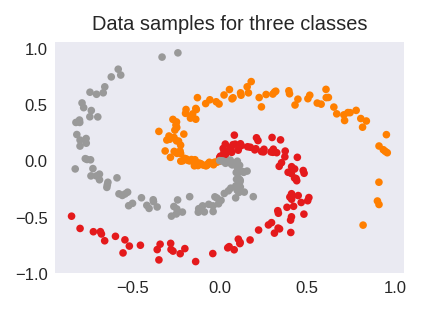

In [1002]:
plt.rcdefaults()
# setting figure global parameters (NOTE: before the figure is created)
plt.rcParams['figure.figsize'] = (3.0, 2.0) # see: https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.rcParams['figure.dpi'] = (150)
#plt.style.use(['seaborn-bright']) # Use it before the fgiure is screated; see: http://www.futurile.net/2016/03/31/colormaps-in-matplotlib/
plt.style.use(['seaborn-dark']) # Use it before the fgiure is screated; see: http://www.futurile.net/2016/03/31/colormaps-in-matplotlib/
#plt.rcParams['axes.labelsize'] = 5
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
# lets visualize the data:
#plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=y, s=7, cmap=plt.cm.Set1)
plt.title('Data samples for three classes')
plt.show()

In [1003]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
LOGDIR = join(LOGDIR_ROOT,now)   # Create a log directory with date and time stamp
                                 # Note that time is given with resoulution of minutes
print("Log data is stored in: ",LOGDIR)

# Only fully connected (FC) layers are used
def add_layer_1(inputs, size_in, size_out, name="FC", layer_type="hidden"):
    """
    layer_type - two values are possible: "hidden" and "output"
    """
    with tf.name_scope(name):
        W = tf.Variable( tf.truncated_normal([size_in, size_out], stddev=0.1, seed=seed_val), \
                         name='W' )
        b = tf.Variable( tf.constant(0.1, shape=[size_out]), name="b")
        if layer_type=="output":
            # Linear activation 
            act = tf.matmul( inputs, W) + b
        else:
            # ReLu activation
            act = tf.nn.relu( tf.matmul( inputs, W) + b )
    return act


Log data is stored in:  /home/damian/GitRepositories/TensorFlow_wormUp_gym/SimpleNN_and_tensorboard/log_01/20180326201156


In [1004]:

tf.reset_default_graph()  # To avoid many duplicated nodes in the default grpah

# define placeholder for inputs to network
#with tf.name_scope('Inputs'):
D_x = tf.placeholder(tf.float32, [None, 2], name='x_input')
D_y = tf.placeholder(tf.float32, [None, 1], name='label')

# NN model building
#with tf.name_scope('All_layers'):
l1 = add_layer_1(D_x, 2, 100)                               # add hidden layer
logits = add_layer_1(l1, 100, 3, layer_type="output")     # add output layer

onehot_labels = tf.one_hot(indices=tf.cast(D_y, tf.int32), depth=3, name='OneHot_label')                           
onehot_labels = tf.reshape(onehot_labels, [-1,3])

#var = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('weights:0')]
var = [v for v in tf.trainable_variables() if v.name == "FC/W:0"]
tf.summary.histogram("Weights_1", var)
var = [v for v in tf.trainable_variables() if v.name == "FC_1/W:0"]
tf.summary.histogram("Weights_2", var)
var = [v for v in tf.trainable_variables() if v.name == "FC/b:0"]
tf.summary.histogram("Bias_1", var)
var = [v for v in tf.trainable_variables() if v.name == "FC_1/b:0"]
tf.summary.histogram("Bias_2", var)

# https://github.com/google/prettytensor/issues/6
#with tf.variable_scope('FC', reuse=True):
#    tf.summary.histogram("Weights_1", tf.get_variable('W'))


# the error between prediciton and real data
with tf.name_scope('loss'):
    loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, \
                            labels=onehot_labels), name="CrossEnt")
    #loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    tf.summary.scalar("loss", loss)

# The training optimization method
with tf.name_scope('train'):
    #train_step = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    train_step = tf.train.AdamOptimizer(1E-2).minimize(loss)  # 1E-4
    

with tf.name_scope("accuracy"):
    argmax_logits = tf.argmax(logits, 1)
    argmax_oh_lab = tf.argmax(onehot_labels, 1)
    correct_prediction = tf.equal(argmax_logits, argmax_oh_lab)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)
    
summ = tf.summary.merge_all()

#hid_activations = l1
#hid_activations_size = 100  # the same as the size of hidden layer

#embedding = tf.Variable(tf.zeros([3, embedding_size]), name="test_embedding")
#assignment = embedding.assign(hid_activations)

writer = tf.summary.FileWriter(LOGDIR, tf.get_default_graph()) # Alternative if session 
                                                                # was not instantiated yet

In [1005]:
print("X shape: ",X.shape)
y = y.reshape(-1,1)
print("y shape: ",y.shape)

X shape:  (300, 2)
y shape:  (300, 1)


In [1006]:
#writer = tf.summary.FileWriter(LOGDIR, sess.graph) 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1500):
        if i % 10 == 0:        
            #print(train_accuracy, trStep, LossVal)
            summ_str = summ.eval(feed_dict={D_x: X, D_y: y})
            writer.add_summary(summ_str, i)
        if i % 100 == 0:
            [train_accuracy] = sess.run([accuracy], feed_dict={D_x: X, D_y: y})
            print("Step: {0},  Train accuracy: {1}".format(i,train_accuracy))
        #[Dy, LossVal, Lgits2, mLogits, ohLabel, mOhLab, corPred] = sess.run([D_y, loss, logits, argmax_logits, \
        #        onehot_labels, argmax_oh_lab, correct_prediction], feed_dict={D_x: X, D_y: y})
        sess.run(train_step, feed_dict={D_x: X, D_y: y})
        
#sess.close()

# direct to the local dir and run this in terminal:
# $ tensorboard --logdir=logs
# Run the following command in virtual environment
# tensorboard --logdir='/home/damian/GitRepositories/TensorFlow_wormUp_gym/SimpleNN_and_tensorboard/log_01'
# Open a browser and go to http://U44SG:6006

Step: 0,  Train accuracy: 0.46000000834465027
Step: 100,  Train accuracy: 0.6800000071525574
Step: 200,  Train accuracy: 0.9399999976158142
Step: 300,  Train accuracy: 0.9766666889190674
Step: 400,  Train accuracy: 0.9900000095367432
Step: 500,  Train accuracy: 0.9933333396911621
Step: 600,  Train accuracy: 0.9933333396911621
Step: 700,  Train accuracy: 0.9933333396911621
Step: 800,  Train accuracy: 0.9933333396911621
Step: 900,  Train accuracy: 0.9933333396911621
Step: 1000,  Train accuracy: 0.9933333396911621
Step: 1100,  Train accuracy: 0.9933333396911621
Step: 1200,  Train accuracy: 0.9933333396911621
Step: 1300,  Train accuracy: 0.9933333396911621
Step: 1400,  Train accuracy: 0.9933333396911621
